In [1]:
from typing import Callable, Dict, List, Tuple
GRAPH_NAME = "Max-cut qiskit (square)"
edges = {(0, 1): 1, (1, 2): 1, (2, 3): 1, (0, 3): 1}
num_nodes = 4

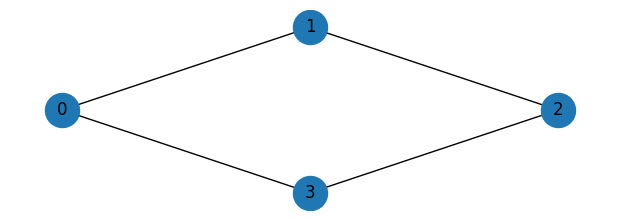

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Imprime un grafo dirigido pesado
# Entrada
#     graph_nodes: Lista de nodos del grafo
#     graph_edges: Diccionario {vértice: peso} donde vértice es (n1, n2)
#     layout:      Para especificar la posición de los nodos
def print_graph(graph_nodes, graph_edges, layout=None):
    G = nx.Graph()

    # Nodes
    G.add_nodes_from(graph_nodes)

    # Edges
    for pair, _ in graph_edges.items():
        G.add_edge(pair[0], pair[1])

    # Print graph
    if layout is None:
        layout = nx.spring_layout(G)

    plt.figure(3, figsize=(6, 2))
    nx.draw(G, layout, with_labels=True, node_size=600)
    #plt.savefig("../../latex/img/qiskit_grafo/qiskit_grafo.png")

print_graph(range(num_nodes), edges, layout={0: [-1, 0], 1: [0, 1],
                                             2: [1, 0],  3: [0, -1]})

In [3]:
# Función de coste binaria con valores {0, 1}
cost_function = "\
-(x_0*(1-x_1) + x_1*(1-x_0) + \
x_1*(1-x_2) + x_2*(1-x_1) + \
x_2*(1-x_3) + x_3*(1-x_2) + \
x_3*(1-x_0) + x_0*(1-x_3))"

# Evalúa una solución concreta según la función de coste para la versión QUBO
# Entrada:
#     - bits: Cadena con los valores de los qubits medidos
#             Orden: q_4 q_3 q_2 q_1 q_0
def eval_cost_function(bits):
    assert num_nodes == len(bits), "Error in cost_function: Length of bits"

    inv_bits = bits[::-1]  # Los qubits están en orden inverso

    param_dict = {}
    # Asignación entre x_ij -> q_n
    # Establecido por el orden de edges. Ej: x_12 -> q_2 (esto es, qubit nº2)
    for i in range(num_nodes):
        param_dict[f"x_{i}"] = int(inv_bits[i])

    return eval(cost_function, param_dict)

In [4]:
# Hallar mínimo de la función clásica por fuerza bruta
import itertools

for z in itertools.product([0, 1], repeat=num_nodes):
    param_dict = dict()
    for i in range(num_nodes):
        param_dict[f"x_{i}"] = z[i]

    print(z, eval(cost_function, param_dict))

(0, 0, 0, 0) 0
(0, 0, 0, 1) -2
(0, 0, 1, 0) -2
(0, 0, 1, 1) -2
(0, 1, 0, 0) -2
(0, 1, 0, 1) -4
(0, 1, 1, 0) -2
(0, 1, 1, 1) -2
(1, 0, 0, 0) -2
(1, 0, 0, 1) -2
(1, 0, 1, 0) -4
(1, 0, 1, 1) -2
(1, 1, 0, 0) -2
(1, 1, 0, 1) -2
(1, 1, 1, 0) -2
(1, 1, 1, 1) 0


In [56]:
from qiskit import QuantumCircuit

def generate_qaoa_circuit(theta):
    assert len(theta) % 2 == 0, "Error in parameters (Beta, Gamma)"

    nqubits = num_nodes
    circuit = QuantumCircuit(nqubits)

    layers = int(len(theta) / 2)
    beta = theta[:layers]
    gamma = theta[layers:]

    # |v0>
    for i in range(nqubits):
        circuit.h(i)

    for p in range(layers):
        circuit.barrier()

        # Hp
        for q_idxs, _ in edges.items():
            circuit.rzz(gamma[p], q_idxs[0], q_idxs[1])

        circuit.barrier()

        # Hm
        #for q_idx in range(nqubits):
        #    circuit.rx(beta[p] * 2, q_idx)

    circuit.save_statevector()
    circuit.measure_all()
    return circuit

In [6]:
def compute_expectation(counts):
    media = 0
    for bits, count in counts.items():
        cost = eval_cost_function(bits)
        media += cost * count

    return media

In [7]:
# Simulador
from qiskit.primitives import Sampler
from scipy.optimize import minimize

shots = 1024
sampler = Sampler(options={"shots": shots})

def execute_circuit(theta):
    qc = generate_qaoa_circuit(theta)
    counts = sampler.run(qc).result().quasi_dists[0].binary_probabilities()
    return compute_expectation(counts)

num_layers = 2
theta_res = minimize(execute_circuit, [1.0, 1.0] * num_layers, method = "COBYLA")
theta_res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.998046875
       x: [ 1.008e+00  1.116e+00  8.847e-01  1.127e+00]
    nfev: 50
   maxcv: 0.0

In [9]:
import numpy as np

def print_matrix(arr: np.array):
    if len(arr.shape) == 1:
        arr = np.array([arr.tolist()])
    arr = np.round(arr, 4)
    max_size = -1
    for row in arr:
        for el in row:
            curr_size = len(str(round(el.real, 4) + round(el.imag, 4) * 1.j))
            if curr_size > max_size:
                max_size = curr_size

    print('\\n'.join([''.join(['{:<{mx}} '.format(e, mx=max_size)
                               for e in row]).rstrip() for row in arr]))

In [57]:
import qiskit.quantum_info as qi
from qiskit import Aer

backend = Aer.get_backend("aer_simulator")

qc = generate_qaoa_circuit([1.0, 1.0])
out_state = backend.run(qc).result().get_statevector()
# print_matrix(np.asarray(out_state))

prob_total = 0
for q_idx in range(num_nodes**2):
    ampl = out_state[q_idx]
    module = np.sqrt(ampl.real**2 + ampl.imag**2)
    prob = module**2
    prob_total += prob
    print(f"P({q_idx:04b}): {prob} {ampl}")

print(f"\nTOTAL: {prob_total}")
# qc.draw()

# print_matrix(np.asarray(qi.Operator(qc)))

P(0000): 0.06250000000000003 (-0.10403670913678562-0.22732435670642048j)
P(0001): 0.06250000000000003 (0.25000000000000006+0j)
P(0010): 0.06250000000000003 (0.25000000000000006+0j)
P(0011): 0.0625 (0.25+0j)
P(0100): 0.06250000000000003 (0.25000000000000006+0j)
P(0101): 0.0625 (-0.1040367091367856+0.22732435670642046j)
P(0110): 0.0625 (0.25+0j)
P(0111): 0.0625 (0.25+0j)
P(1000): 0.06250000000000003 (0.25000000000000006+0j)
P(1001): 0.0625 (0.25+0j)
P(1010): 0.0625 (-0.1040367091367856+0.22732435670642046j)
P(1011): 0.0625 (0.25+0j)
P(1100): 0.0625 (0.25+0j)
P(1101): 0.0625 (0.25+0j)
P(1110): 0.0625 (0.25+0j)
P(1111): 0.06249999999999997 (-0.10403670913678556-0.22732435670642037j)

TOTAL: 1.0


In [ ]:
# p = 1
theta = [1.132, 0.6577]

# p = 2
theta = [1.014, 1.118, 0.8536, 1.098]

# p = 3
theta = [1.586, 1.187, 0.7835, 0.6822, 0.8811, 0.8062]


shots = 1024
sampler = Sampler(options={"shots": shots})

qc = generate_qaoa_circuit(theta)
counts = sampler.run(qc).result().quasi_dists[0].binary_probabilities()

plot_histogram(counts)

In [ ]:
from qiskit.visualization import plot_histogram

shots = 1024
sampler = Sampler(options={"shots": shots})

qc = generate_qaoa_circuit(theta_res.x)
counts = sampler.run(qc).result().quasi_dists[0].binary_probabilities()

plot_histogram(counts, figsize=(13, 6.83))

In [ ]:
# Gamma function
import numpy as np
import matplotlib.pyplot as plt

def gamma_function():
    x = np.linspace(0.3, 6, 300)
    y = []
    beta = 1.0
    for gamma in x:
        y.append(execute_circuit([beta, gamma]))

    plt.plot(x, y)
    #plt.savefig("../../latex/img/qiskit_grafo/gamma_fun_2d.png")
    plt.show()

gamma_function()

In [ ]:
# 3D Gamma function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools

def gamma_function_3d():
    beta = np.arange(0.3, 6, (6-0.3)/120)
    gamma = np.arange(0.3, 6, (6-0.3)/120)
    beta, gamma = np.meshgrid(beta, gamma)
    z = np.zeros([len(beta), len(beta)])

    for i in range(len(beta)):
        for j in range(len(beta)):
            z[i][j] = execute_circuit([beta[i][j], gamma[i][j]])

    fig = plt.figure()
    axis = plt.axes(projection='3d')
    figure = axis.plot_surface(gamma, beta, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(figure, shrink=0.5, aspect=5)
    plt.savefig("../../latex/img/qiskit_grafo/gamma_fun_3d.png")
    plt.show()

gamma_function_3d()

In [ ]:
# Statistics

shots = 1024
sampler = Sampler(options={"shots": shots})

def max_global_statistics(num_layers=1, num_generations=1000) -> Tuple[Dict[str, float],
                                                                       Dict[str, float]]:
    max_statistics = {}
    global_statistics = {}
    for iteration in range(0, num_generations):
        theta_res = minimize(execute_circuit, [1.0, 1.0] * num_layers, method = "COBYLA")
        qc = generate_qaoa_circuit(theta_res.x)
        counts = sampler.run(qc).result().quasi_dists[0].binary_probabilities()

        # Max statistics
        max_path = max(counts, key=counts.get)
        if max_path not in max_statistics:
            max_statistics[max_path] = 0
        max_statistics[max_path] += 1

        # Global statistics
        for (path, num_appearances) in counts.items():
            if path not in global_statistics:
                global_statistics[path] = 0
            global_statistics[path] += num_appearances

    for path in global_statistics:
        global_statistics[path] = global_statistics[path] / shots / num_generations  # Normalize

    for path in max_statistics:
        max_statistics[path] = max_statistics[path] / num_generations  # Normalize

    max_statistics = sorted(max_statistics.items(), key=lambda x: x[1], reverse=True)
    global_statistics = sorted(global_statistics.items(), key=lambda x: x[1], reverse=True)

    return max_statistics, global_statistics


print(GRAPH_NAME + ":\n")
interval_num_layers = (1, 3)
for p in range(interval_num_layers[0], interval_num_layers[1] + 1):
    max_st, global_st = max_global_statistics(num_layers=p, num_generations=100)
    print(f"Max statistics (p = {p}): ", str(max_st))
    print(f"Global statistics (p = {p}): ", str(global_st))
    print()

In [ ]:
!dunstify -t $((30* 1000*60)) --urgency=critical "Ejecución completada"